In [1]:
!pwd

/home/giakhang/dev/multi_task_autopilot/YOLOF-Mask/demo


In [3]:
%cd /home/giakhang/dev/multi_task_autopilot/YOLOF-Mask

/home/giakhang/dev/multi_task_autopilot/YOLOF-Mask


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import torch

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.data.datasets import register_coco_instances

In [5]:
dataset = 'bdd100k'
annot_dir = f"./{dataset}/labels_coco/ins_seg"
imgs_dir = "./{}/images/10k/{}"

for split in ['train', 'val']:
    annot_path = os.path.join(annot_dir, f"ins_seg_{split}_coco.json")
    d_name = dataset + f'_{split}'
    register_coco_instances(d_name, {}, annot_path, imgs_dir.format(dataset, split))

# Load dataset
dataset_dicts = DatasetCatalog.get('bdd100k_train')
metadata = MetadataCatalog.get('bdd100k_train')

[11/09 19:39:34 d2.data.datasets.coco]: Loading ./bdd100k/labels_coco/ins_seg/ins_seg_train_coco.json takes 1.30 seconds.
[11/09 19:39:34 d2.data.datasets.coco]: Loaded 7000 images in COCO format from ./bdd100k/labels_coco/ins_seg/ins_seg_train_coco.json


In [6]:
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig
from detectron2.config.instantiate import instantiate
from detectron2.engine import DefaultPredictor

cfg = LazyConfig.load("yolof_mask/configs/yolof_mask/yolofmask_r_50_1x.py")

cfg.train.device = 'cuda:0'
cfg.dataloader.evaluator.dataset_name = 'bdd100k_val'
cfg.dataloader.train.dataset.names = 'bdd100k_train'
cfg.dataloader.test.dataset.names = 'bdd100k_val'
cfg.dataloader.train.total_batch_size = 16

cfg.model.num_classes = 8
cfg.model.yolof.num_classes = 8
cfg.model.mask_head.num_classes = 8

cfg.train.init_checkpoint = "/home/giakhang/dev/multi_task_autopilot/YOLOF-Mask/output/yolofmask_r_50_1x/model_0179999.pth"

In [8]:
from yolof_mask.engine.default_predictor import DefaultPredictor

predictor = DefaultPredictor(cfg)
predictor.model.yolof.score_threshold = 0.4

[11/09 19:39:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/giakhang/dev/multi_task_autopilot/YOLOF-Mask/output/yolofmask_r_50_1x/model_0179999.pth ...


In [24]:
predictor.model.device

device(type='cuda', index=0)

In [25]:
annType = ['segm','bbox','keypoints']
annType = annType[0]      #specify type here

In [30]:
im = cv2.imread("/home/giakhang/dev/multi_task_autopilot/YOLOF-Mask/bdd100k/images/10k/test/fd866470-7cc453f1.jpg")
predictions = predictor(im)

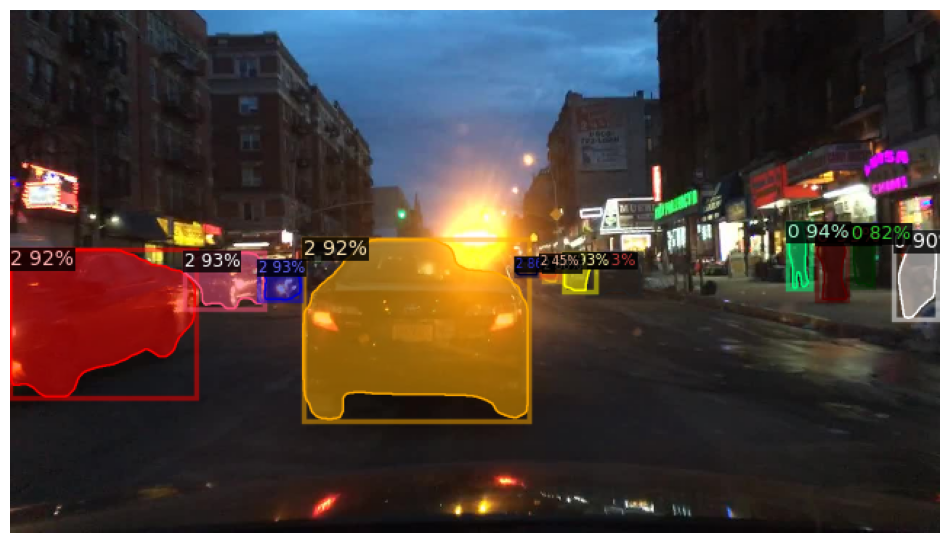

In [31]:
from detectron2.utils.visualizer import ColorMode

plt.figure(figsize=(12, 8))
v = Visualizer(im[:, :, ::-1],
               scale=0.5, 
               metadata=MetadataCatalog.get("bdd100k_val")
               #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(predictions["instances"].to("cpu"))
#axs[0].imshow(im[:, :, ::-1])
plt.axis('off')

plt.imshow(out.get_image())

In [ ]:
import json
import cv2
import os
from tqdm import tqdm

from pycocotools.mask import encode as cvt_mask_to_rle
from pycocotools.mask import decode as cvt_rle_to_mask

annType = 'segm'
annot_info_file = '/Users/giakhang/dev/work/research_autopilot/dataset_zoo/coco_test_annotations/image_info_test-dev2017.json'
img_dir = '/Users/giakhang/dev/work/research_autopilot/dataset_zoo/coco_test2017'

coco_ids = list(MetadataCatalog.get("coco2017_val").thing_dataset_id_to_contiguous_id.keys())
model_ids = list(MetadataCatalog.get("coco2017_val").thing_dataset_id_to_contiguous_id.values())

results_file = './detections_test-dev2017_yolof_mask_results.json'
if os.path.exists(results_file):
    os.remove(results_file)
fp = open(results_file, 'w')
fp.close()

with open(annot_info_file, 'r') as file:
    annots = json.load(file)

num_imgs = len(annots['images'])

def convert_bbox_xyxy_to_xywh(x1, y1, x2, y2):
    w = x2 - x1
    h = y2 - y1
    return [x1, y1, w, h]

with open(results_file, 'a') as file:
    for i, image in enumerate(tqdm(annots['images'])):

        if i == 0:
            file.write('[')
        else:
            file.write(',')

        file_name = image['file_name']
        image_id = image['id']
        results_each_img = []

        if (file_name is None) or (image_id is None):
            print('file_name or image_id is null')

        image_path = os.path.join(img_dir, file_name)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Failed to read image: {image_path}")

        predictions = predictor(img)
        output = predictions['instances']
        pred_boxes = output.pred_boxes.tensor.to('cpu')
        pred_masks = output.pred_masks.to('cpu')
        pred_cls_ids = output.pred_classes.to('cpu')
        pred_confs = output.scores.to('cpu')
        assert pred_boxes.size()[0] == pred_masks.size()[0] == pred_cls_ids.size()[0] == pred_confs.size()[0]

        for j in range(pred_boxes.size()[0]):
            box, mask, model_cls_id, conf = pred_boxes[j], pred_masks[j], pred_cls_ids[j], pred_confs[j]
            pred_coco_id = coco_ids[model_cls_id.item()]
            result = {"image_id": image_id, 
                      "category_id": pred_coco_id, 
                      "score": round(conf.item(), 3)}

            if annType == "bbox":
                result["bbox"] = convert_bbox_xyxy_to_xywh(*box.tolist())
            elif annType == 'segm':
                mask = mask.numpy().astype(np.uint8)
                mask = np.asfortranarray(mask)
                rle = cvt_mask_to_rle(mask)
                rle["counts"] = rle["counts"].decode()
                result["segmentation"] = rle
            else:
                print("Wronge annType")

            results_each_img.append(result)

        # Write result to file
        file.write(json.dumps(results_each_img)[1:-1])

        if i == num_imgs - 1:
            file.write(']')

  0%|                                       | 5/20288 [00:04<5:08:50,  1.09it/s]

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import pylab

In [12]:
annType = ['segm','bbox','keypoints']
annType = annType[0]      #specify type here
prefix = 'person_keypoints' if annType=='keypoints' else 'instances'
print('Running demo for *%s* results.'%(annType))

#initialize COCO ground truth api
dataDir='./coco2017'
dataType='val2017'
annFile = '%s/annotations/%s_%s.json'%(dataDir, prefix, dataType)
cocoGt=COCO(annFile)

Running demo for *segm* results.
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


In [14]:
#initialize COCO detections api
#resFile='./results/%s_%s_fake%s100_results.json'
#resFile = resFile%(prefix, dataType, annType)
cocoDt=cocoGt.loadRes('./test_dev_segm_results.json')

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!


In [15]:
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=3.48s).
Accumulating evaluation results...
DONE (t=0.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100